<a href="https://colab.research.google.com/github/YinYinTan/CIND820FinalProject/blob/main/4_Random_Forest_Classification_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest Classification Models

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import time

In [ ]:
#Read file
df = pd.read_csv('3a. Working Dataset.csv', index_col=None)

# 1. All Features in Working Dataset - Evaluation using Train-Test Split

In [ ]:
#Split dataframe, using 80% for training and 20% for testing
from sklearn.model_selection import train_test_split

X = df.drop(['Worse_MH'],axis=1)
y = df['Worse_MH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, stratify=y)

In [ ]:
#Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
smote = SMOTE(random_state = 888)
X_train, y_train = smote.fit_resample(X_train, y_train)

#Random forest classification model

t1 = time.perf_counter() #time counter start

model = RandomForestClassifier(random_state=888)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

t2 = time.perf_counter() #time counter ends

#Save results into dictionary
rf_all = {'Accuracy':metrics.accuracy_score(y_test, y_pred), 'Precision':metrics.precision_score(y_test, y_pred),'Recall':metrics.recall_score(y_test, y_pred),\
          'F1-Score':metrics.f1_score(y_test, y_pred),'AUC':metrics.roc_auc_score(y_test, y_pred),'Brier Score':metrics.brier_score_loss(y_test, y_pred),'Execution Time':int(t2-t1)}

#Evaluation of random forest classification model
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-score:", metrics.f1_score(y_test, y_pred))
print("Area Under Curve (AUC):", metrics.roc_auc_score(y_test, y_pred))
print("Brier Score:", metrics.brier_score_loss(y_test, y_pred))
print('Execution time in seconds:', int(t2-t1))

Accuracy: 0.7517321016166282
Precision: 0.8331877729257642
Recall: 0.7996647108130763
F1-score: 0.8160821214713431
Area Under Curve (AUC): 0.7226523925122894
Brier Score: 0.24826789838337182
Execution time in seconds: 3


# 2. All Features in Working Dataset - Hyperparameter Tuning

### 2.1 Random Search with Cross Validation
In this section, a grid of hyperparameter ranges will be defined, and randomly sampled from the grid, where k-fold cross validation will be performed with each combination of values.

In [ ]:
from pprint import pprint

#Look at parameters currently used by the model
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 888,
 'verbose': 0,
 'warm_start': False}


The following set of hyperparameters will be adjusted to narrow down the best combination of parameters:
*   n_estimators = number of trees in the foreset
*   max_features = max number of features considered for splitting a node
*   max_depth = max number of levels in each decision tree
*   min_samples_split = min number of data points placed in a node before the node is split
*   min_samples_leaf = min number of data points allowed in a leaf node
*   bootstrap = method for sampling data points (with or without replacement)

In [ ]:
#Creation of a parameter grid to sample from during fitting. On each iteration, the algorithm will choose a different, random combination of parameter values.

from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [10, 20, 30, 40, 50]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000]}


In [ ]:
#Using the random grid to search for best parameters

#Create the base model to tune
model = RandomForestClassifier(random_state=888)

#Random search of parameters across 100 different combinations, using 3 fold cross validation
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 50, cv = 3, scoring = 'recall', verbose=2, random_state=42, n_jobs = -1)

#Fit the random search model
model_random.fit(X_train, y_train)

#View the best parameters from fitting the random search (based on model with the best recall)
model_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [ ]:
#Evaluation of best model from random search
best = model_random.best_estimator_
y_pred=best.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-score:", metrics.f1_score(y_test, y_pred))
print("Area Under Curve (AUC):", metrics.roc_auc_score(y_test, y_pred))
print("Brier Score:", metrics.brier_score_loss(y_test, y_pred))

Accuracy: 0.7575057736720554
Precision: 0.8256107834877844
Recall: 0.8214585079631181
F1-score: 0.8235294117647058
Area Under Curve (AUC): 0.7187069905307242
Brier Score: 0.24249422632794457


Compared to the default random forest parameters used in the prior "All Features in Working Dataset - Evaluation using Train-Test Split" section, the best model from the grid search only resulted in a 2% increase in Recall (the metric chosen for scoring).
*   Accuracy increased by 0.6% and the F1-score increased by 0.7%, whereas the Precision, AUC, and Brier Score actually decreased by 0.8%, 0.4%, and 0.6% respectively.

The best model found in the random search actually has the same values for 2 of the 6 parameters as the default model (i.e. min_samples_leaf = 1 and min_samples_split = 2).

### 2.2 Grid Search with Cross Validation
The random search above narrowed down the range for each hyperparameter. In this section, every combination of settings is defined.

In [ ]:
from sklearn.model_selection import GridSearchCV

#Create the parameter grid based on the results of previous random search. This will try out 1 * 3 * 3 * 2 * 2 * 3 = 108 combinations of settings.
param_grid = {
    'bootstrap': [False],
    'max_depth': [50, 60, 70],
    'max_features': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 3],
    'n_estimators': [1000, 1100, 1200]
}

#Create the base model to tune
model = RandomForestClassifier(random_state=888)

#Instantiate the grid search model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, scoring = 'recall', n_jobs = -1, verbose = 2)

#Fit the grid search model
grid_search.fit(X_train, y_train)

#View the best parameters from fitting the grid search (based on model with the best recall)
grid_search.best_params_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'bootstrap': False,
 'max_depth': 50,
 'max_features': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 1000}

In [ ]:
#Evaluate performance of best model from grid search
best = grid_search.best_estimator_
y_pred=best.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-score:", metrics.f1_score(y_test, y_pred))
print("Area Under Curve (AUC):", metrics.roc_auc_score(y_test, y_pred))
print("Brier Score:", metrics.brier_score_loss(y_test, y_pred))

Accuracy: 0.7580831408775982
Precision: 0.8219633943427621
Recall: 0.8281642917015927
F1-score: 0.8250521920668058
Area Under Curve (AUC): 0.715566375906455
Brier Score: 0.24191685912240185


Compared to the default random forest parameters used in the prior "All Features in Working Dataset - Evaluation using Train-Test Split" section, the best model from the random search only resulted in a 2.8% increase in Recall (the metric chosen for scoring).
*   Accuracy increased by 0.6% and the F1-score increased by 0.9%, whereas the Precision, AUC, and Brier Score actually decreased by 1.1%, 0.7%, and 0.6% respectively.

The best model found in the grid search actually has the same value for 1 of the 6 parameters as the default model (i.e. min_samples_leaf = 1).

# 3. All Features in Working Dataset, Using Parameters from Grid Search - Evaluation using Repeated 10-fold Cross Validation

In [ ]:
X = df.drop(['Worse_MH'],axis=1)
y = df['Worse_MH']

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

#Set cross-validation to 10-folds, repeated 3 times
folds = 10
repeats = 3
rkf = RepeatedStratifiedKFold(n_splits=folds, n_repeats=repeats, random_state=888)

#Random forest classification model
model = RandomForestClassifier(bootstrap='False', max_depth=50, max_features=5, min_samples_leaf=1, min_samples_split=3, n_estimators=1000, random_state=888)

#Performance metrics
accuracy = precision = recall = f1 = auc = brier = ex_time = 0

for train_index, test_index in rkf.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  #Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
  smote = SMOTE(random_state = 888)
  X_train, y_train = smote.fit_resample(X_train, y_train)

  t1 = time.perf_counter() #time counter start

  model.fit(X_train, y_train)
  y_pred=model.predict(X_test)

  t2 = time.perf_counter() #time counter ends

  accuracy = accuracy + metrics.accuracy_score(y_test, y_pred)
  precision = precision + metrics.precision_score(y_test, y_pred)
  recall = recall + metrics.recall_score(y_test, y_pred)
  f1 = f1 + metrics.f1_score(y_test, y_pred)
  auc = auc + metrics.roc_auc_score(y_test, y_pred)
  brier = brier + metrics.brier_score_loss(y_test, y_pred)
  ex_time = ex_time + t2-t1

#Save results into dictionary
rf_all_tuned = {'Accuracy':accuracy/(folds*repeats), 'Precision':precision/(folds*repeats),'Recall':recall/(folds*repeats),\
          'F1-Score':f1/(folds*repeats),'AUC':auc/(folds*repeats),'Brier Score':brier/(folds*repeats),'Execution Time (sec)':ex_time/(folds*repeats)}

#Evaluation of random forest classification model
print("Accuracy:", accuracy/(folds*repeats))
print("Precision:", precision/(folds*repeats))
print("Recall:", recall/(folds*repeats))
print("F1-score:", f1/(folds*repeats))
print("Area Under Curve (AUC):", auc/(folds*repeats))
print("Brier Score:", brier/(folds*repeats))
print('Execution time in seconds:', ex_time/(folds*repeats))

Accuracy: 0.756028823220457
Precision: 0.8263128688658546
Recall: 0.8177267749418211
F1-score: 0.8219582570176925
Area Under Curve (AUC): 0.7186036472111705
Brier Score: 0.24397117677954286
Execution time in seconds: 28.85601256460007


# 4A. Selected Features - Filter Method

## 4A.1 Top 20 Features Ranked by Importance

In [27]:
#Identify top 20 features based on model above
feature_names = df.drop(['Worse_MH'],axis=1).columns

feature_imp = pd.Series(model.feature_importances_,index=feature_names).sort_values(ascending=False)
feature_imp = feature_imp[:20]

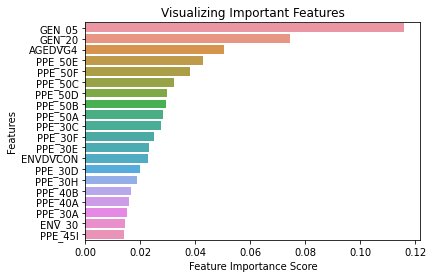

In [28]:
#Plot top 20 features
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

## 4A.2 Top 1 to 10 Features - Filter Method
Based on the bar graph above, it was decided to build random forest models using only the top 1 to 10 features to compare performance.

In [32]:
#Build classification model using 1 to 10 of the top features and compare performance on Recall

recall_test = []

for n in range(9):
  #Obtain names of top n variables
  top = feature_imp[:n].index

  #Split dataframe, using 80% for training and 20% for testing
  #Only select top n variables for X
  X = df.loc[:,top]
  y = df['Worse_MH']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, stratify=y)

  #Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
  smote = SMOTE(random_state = 888)
  X_train, y_train = smote.fit_resample(X_train, y_train)

  #Random forest classification model
  model = RandomForestClassifier(bootstrap='False', max_depth=50, max_features=5, min_samples_leaf=1, min_samples_split=3, n_estimators=1000, random_state=888)
  model.fit(X_train, y_train)
  y_pred=model.predict(X_test)

  #Save results into list
  recall_test.append(metrics.recall_score(y_test, y_pred))

#Plot recall scores against number of features used
plt.plot(recall_test)
plt.ylabel('Recall Score')
plt.show()

ValueError: ignored

???Conclusion

## 4A.3 Top 5 Features, Filter Method - Evaluation using Repeated 10-fold Cross Validation
Based on the results above, it was decided to build a random forest model using only the top 5 features.

In [ ]:
#Obtain names of top 5 variables
top_five = feature_imp[:5].index
top_five

#Only select top 5 variables for X
X = df.loc[:,top_five]
y = df['Worse_MH']

Index(['GEN_05', 'GEN_20', 'AGEDVG4', 'PPE_50E', 'PPE_50F'], dtype='object')

In [ ]:
#Set cross-validation to 10-folds, repeated 3 times
folds = 10
repeats = 3
rkf = RepeatedStratifiedKFold(n_splits=folds, n_repeats=repeats, random_state=888)

#Random forest classification model
model = RandomForestClassifier(bootstrap='False', max_depth=50, max_features=5, min_samples_leaf=1, min_samples_split=3, n_estimators=1000, random_state=888)

#Performance metrics
accuracy = precision = recall = f1 = auc = brier = ex_time = 0

for train_index, test_index in rkf.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  #Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
  smote = SMOTE(random_state = 888)
  X_train, y_train = smote.fit_resample(X_train, y_train)

  t1 = time.perf_counter() #time counter start

  model.fit(X_train, y_train)
  y_pred=model.predict(X_test)

  t2 = time.perf_counter() #time counter ends

  accuracy = accuracy + metrics.accuracy_score(y_test, y_pred)
  precision = precision + metrics.precision_score(y_test, y_pred)
  recall = recall + metrics.recall_score(y_test, y_pred)
  f1 = f1 + metrics.f1_score(y_test, y_pred)
  auc = auc + metrics.roc_auc_score(y_test, y_pred)
  brier = brier + metrics.brier_score_loss(y_test, y_pred)
  ex_time = ex_time + t2-t1

#Save results into dictionary
rf_five_features_filter = {'Accuracy':accuracy/(folds*repeats), 'Precision':precision/(folds*repeats),'Recall':recall/(folds*repeats),\
          'F1-Score':f1/(folds*repeats),'AUC':auc/(folds*repeats),'Brier Score':brier/(folds*repeats),'Execution Time (sec)':ex_time/(folds*repeats)}

#Evaluation of random forest classification model
print("Accuracy:", accuracy/(folds*repeats))
print("Precision:", precision/(folds*repeats))
print("Recall:", recall/(folds*repeats))
print("F1-score:", f1/(folds*repeats))
print("Area Under Curve (AUC):", auc/(folds*repeats))
print("Brier Score:", brier/(folds*repeats))
print('Execution time in seconds:', ex_time/(folds*repeats))

Accuracy: 0.7497158192610499
Precision: 0.8273847184590665
Recall: 0.8045377256591861
F1-score: 0.8157550105953228
Area Under Curve (AUC): 0.7164618127368286
Brier Score: 0.25028418073895
Execution time in seconds: 3.4287806735334017


## Top 10 Features - Filter Method
A random forest model using the top 10 features, to see if model performance improves.

In [ ]:
#Obtain names of top 10 variables
top_ten = feature_imp[:10].index
top_ten

Index(['GEN_05', 'GEN_20', 'AGEDVG4', 'PPE_50E', 'PPE_50F', 'PPE_50C',
       'PPE_50D', 'PPE_50B', 'PPE_30C', 'PPE_50A'],
      dtype='object')

In [ ]:
#Split dataframe, using 80% for training and 20% for testing
from sklearn.model_selection import train_test_split

#Only select top 10 variables for X
X = df.loc[:,top_ten]
y = df['Worse_MH']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, stratify=y)

In [ ]:
#Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
smote = SMOTE(random_state = 888)
X_train, y_train = smote.fit_resample(X_train, y_train)

#Random forest classification model

t1 = time.perf_counter() #time counter start

model = RandomForestClassifier(bootstrap='False', max_depth=50, max_features=5, min_samples_leaf=1, min_samples_split=3, n_estimators=1000, random_state=888)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

t2 = time.perf_counter() #time counter ends

print('Execution time in seconds:', int(t2-t1), "\n")

#Save results into dictionary
rf_ten_features_filter = {'Accuracy':metrics.accuracy_score(y_test, y_pred), 'Precision':metrics.precision_score(y_test, y_pred),'Recall':metrics.recall_score(y_test, y_pred),\
          'F1-Score':metrics.f1_score(y_test, y_pred),'AUC':metrics.roc_auc_score(y_test, y_pred),'Brier Score':metrics.brier_score_loss(y_test, y_pred),'Execution Time':int(t2-t1)}

#Evaluation of random forest classification model
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-score:", metrics.f1_score(y_test, y_pred))
print("Area Under Curve (AUC):", metrics.roc_auc_score(y_test, y_pred))
print("Brier Score:", metrics.brier_score_loss(y_test, y_pred))

Execution time in seconds: 1 

Accuracy: 0.7297921478060047
Precision: 0.8310502283105022
Recall: 0.7627829002514669
F1-score: 0.7954545454545454
Area Under Curve (AUC): 0.7097773499402047
Brier Score: 0.2702078521939954


# 4B. 5 Selected Features using Recursive Feature Elimination (RFE) - Wrapper Method

In [ ]:
#Split dataframe, using 80% for training and 20% for testing
from sklearn.model_selection import train_test_split

X = df.drop(['Worse_MH'],axis=1)
y = df['Worse_MH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, stratify=y)

In [ ]:
#Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
smote = SMOTE(random_state = 888)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
#Random forest classification model with RFE for 5 features

t1 = time.perf_counter() #time counter start

model = RandomForestClassifier(bootstrap='False', max_depth=50, max_features=5, min_samples_leaf=1, min_samples_split=3, n_estimators=1000, random_state=888)

#5 chosen as the number of features based on the previous models using the filter method for feature selection, where 5 features performed similarly to 10
rfe = RFE(estimator=model, n_features_to_select=5) 
fit = rfe.fit(X_train, y_train)

t2 = time.perf_counter() #time counter ends

for feature in fit.support_.nonzero():
  print('5 selected features:', X_train.columns[feature])

print('Execution time in seconds:', int(t2-t1))

5 selected features: Index(['PPE_50A', 'PPE_50C', 'PPE_50E', 'GEN_05', 'GEN_20'], dtype='object')
Execution time in seconds: 128


In [ ]:
y_pred=fit.predict(X_test)

#Save results into dictionary
rf_five_features_rfe = {'Accuracy':metrics.accuracy_score(y_test, y_pred), 'Precision':metrics.precision_score(y_test, y_pred),'Recall':metrics.recall_score(y_test, y_pred),\
          'F1-Score':metrics.f1_score(y_test, y_pred),'AUC':metrics.roc_auc_score(y_test, y_pred),'Brier Score':metrics.brier_score_loss(y_test, y_pred),'Execution Time':int(t2-t1)}

#Evaluation of random forest classification model
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-score:", metrics.f1_score(y_test, y_pred))
print("Area Under Curve (AUC):", metrics.roc_auc_score(y_test, y_pred))
print("Brier Score:", metrics.brier_score_loss(y_test, y_pred))

Accuracy: 0.6986143187066974
Precision: 0.8465909090909091
Recall: 0.6869237217099748
F1-score: 0.7584451642757983
Area Under Curve (AUC): 0.7057067588141711
Brier Score: 0.30138568129330257


# 5. Comparison of Models

In [ ]:
#Combine performance metrics for all models into one dataframe
comparison = pd.DataFrame([rf_all, rf_all_tuned, rf_five_features_filter, rf_ten_features_filter, rf_five_features_rfe], index=['RF All Features','RF All Features - Tuned','RF 5 Features - Filter','RF 10 Features - Filter','RF 5 Features - RFE'])
comparison

,Accuracy,Precision,Recall,F1-Score,AUC,Brier Score,Execution Time
RF All Features,0.751732,0.833188,0.799665,0.816082,0.722652,0.248268,2
RF 5 Features - Filter,0.732390,0.852245,0.739732,0.792013,0.727936,0.267610,1
RF 10 Features - Filter,0.729792,0.831050,0.762783,0.795455,0.709777,0.270208,1
RF 5 Features - RFE,0.698614,0.846591,0.686924,0.758445,0.705707,0.301386,128


The random forest model using all features had the best accuracy, recall, F1-Score, and Brier Score. 

# 6. Stability of Best Model by Varying k-folds for Cross Validation

In [ ]:
recall_test = []

for k in range(3, 15, 1):
  #Set cross-validation to k-folds, repeated 3 times
  repeats = 3
  rkf = RepeatedStratifiedKFold(n_splits=k, n_repeats=3, random_state=888)

  #Random forest classification model
  model = RandomForestClassifier(bootstrap='False', max_depth=50, max_features=5, min_samples_leaf=1, min_samples_split=3, n_estimators=1000, random_state=888)

  #Performance metrics
  recall = 0

  for train_index, test_index in rkf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
    smote = SMOTE(random_state = 888)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)

    recall = recall + metrics.recall_score(y_test, y_pred)

  #Calculate average recall, append to list
  recall_test.append(recall/(k*repeats))

#Plot recall scores against number of features used
plt.plot(recall_test)
plt.ylabel('Recall Score')
plt.show()